#  Batch Normalization 理解

## BN 为了解决什么问题？
1. 在训练神经网络的时候，随着训练参数的更新，每一层的输出都会随之改变，导致每一层神经元的分布一直在变化。这就是论文中所谓的 Internal Covariate Shift 问题。
2. 梯度消失或梯度爆炸问题。考虑 sigmoid 激活函数。g(x) = 1/(1+exp(-x))， g'(x) = g(x) * (1 - g(x))。当 |x| 变大时，g'(x) 趋近于0。因此对于 x = wu+b，反向传播给u的梯度就会趋近于0。

## BN 如何解决这些问题？
（以下的输入在 BN 中都是指激活函数前的值，如 sigmoid(wx+b)，输入是指wx+b）

对每一层的输入做白化是解决输入数据分布不一致的通常做法，但是做白化需要对每一层的输入单元一起做，这导致计算代价很大求导很复杂。

因此，BN做了两个简化。

1. 对于输入的每个神经元做归一化，而不是输入的整体做归一化。（虽然输入的每一维不一定是无关的）
2. 做归一化的时候不是针对整个训练数据求均值和方差，而是用每一个 mini-batch 的均值和方差作为整体数据的估计值。这一点和 sgd 的思路很像，用 mini-batch 的梯度代表整个 batch 的梯度。

如果把每层的输入直接归一化到均值为0，方差为1，那么网络的表达能力就被我们强制降低了。因此，在归一化之后，BN 还要将分布映射到均值为u,方差为σ的分布上去。

在 inference 阶段和在 train 阶段有一丝差别，在 train 的时候我们可以根据 mini-batch 计算输入的均值和方差，但是在 inference 的时候不能因为只输入一个样本就不让 inference 把。。因此，在 inference 阶段，输入的均值和方差是固定住的。均值是训练时候所有均值的平均，方差是训练时候所有方差的无偏估计。在实际实现的时候可以用 moving average 来计算这两个值，而不用把结果都存下来。


## BN 的优势
1. 可以选择很大的学习率，加速收敛。在训练NN的时候，学习率选择太大容易导致梯度消失或者爆炸（链式求导的连乘）。而有了 BN 之后，参数的 scale 影响会减小。（可以看论文推导一遍）
2. 不需要很小心地去初始化参数。原因同上。

## Reference
* [Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift](http://proceedings.mlr.press/v37/ioffe15.pdf)
* [知乎讨论：为什么BN效果好](https://www.zhihu.com/question/38102762)
* [Implementing Batch Normalization in Tensorflow](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html)
* [What is an explanation of the example of why batch normalization has to be done with some care?
](https://stats.stackexchange.com/questions/215458/what-is-an-explanation-of-the-example-of-why-batch-normalization-has-to-be-done)
* [不同learning rate 不同权重下，BN与非BN对比](https://github.com/NELSONZHAO/zhihu/blob/master/batch_normalization_discussion/batch_norm_discussion.ipynb)


## 复现论文中的第一个实验

用 BN 和不用 BN 对 MNIST 分类问题的影响

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
print(tf.__version__)

1.14.0


W0711 22:38:26.810965  3636 deprecation.py:323] From <ipython-input-3-279a5b47b21f>:53: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0711 22:38:26.810965  3636 deprecation.py:323] From C:\Users\zhipwang\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0711 22:38:26.810965  3636 deprecation.py:323] From C:\Users\zhipwang\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future

Extracting MINIT_data/train-images-idx3-ubyte.gz


W0711 22:38:27.467211  3636 deprecation.py:323] From C:\Users\zhipwang\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MINIT_data/train-labels-idx1-ubyte.gz


W0711 22:38:27.482834  3636 deprecation.py:323] From C:\Users\zhipwang\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Extracting MINIT_data/t10k-images-idx3-ubyte.gz
Extracting MINIT_data/t10k-labels-idx1-ubyte.gz


W0711 22:38:27.607822  3636 deprecation.py:323] From C:\Users\zhipwang\AppData\Roaming\Python\Python36\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0711 22:38:28.264061  3636 deprecation.py:323] From <ipython-input-3-279a5b47b21f>:41: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).



Extracting MINIT_data/train-images-idx3-ubyte.gz
Extracting MINIT_data/train-labels-idx1-ubyte.gz
Extracting MINIT_data/t10k-images-idx3-ubyte.gz
Extracting MINIT_data/t10k-labels-idx1-ubyte.gz


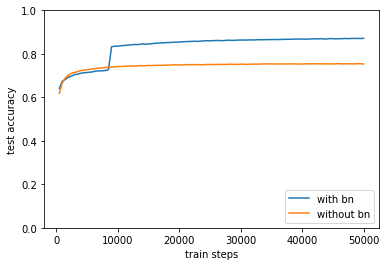

In [3]:
class ANN:
    def __init__(self, use_bn, learning_rate, num_layers=3, hidden_size=100):
        self.x = tf.placeholder(tf.float32, shape=(None, 784))
        self.labels = tf.placeholder(tf.float32, shape=[None, 10])
        self.is_training = tf.placeholder(tf.bool)
        self.global_step = tf.Variable(0, trainable=False)
        
        # Hidden layers.
        with tf.name_scope('hidden'):
            layer_output = self.x
            for i in range(num_layers):
                layer_output = self._full_connect(layer_output, hidden_size, use_bn)
        
        # Output layer.
        with tf.name_scope('output'):
            self.logits = self._full_connect(layer_output, 10, False)

        # Loss
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.labels, logits=self.logits))
            if use_bn:
                with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                    self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss, global_step=self.global_step)
            else:
                self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss, global_step=self.global_step)
    
        # Accuracy
        with tf.name_scope('accuracy'):
            self.predicts = tf.argmax(self.logits, 1)
            self.true_labels = tf.argmax(self.labels, 1)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predicts, self.true_labels), tf.float32))
        
    def _full_connect(self, _input, output_size, use_bn):
        input_size = _input.shape[1].value
        init_weights = tf.random.normal([input_size, output_size])
        init_bias = tf.zeros([output_size])
        weights = tf.Variable(init_weights, trainable=True)
        bias = tf.Variable(init_bias, trainable=True)
        linear_output = tf.add(tf.matmul(_input, weights), bias)
        if use_bn:
            linear_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
        return tf.nn.sigmoid(linear_output)


def train(use_bn):
    num_steps = 50000
    batch_size = 60
    learning_rate = 1.0
    test_every_steps = 500 

    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('MINIT_data/', one_hot=True)
    
    steps = []
    test_acc = []

    with tf.Session() as sess:
        model = ANN(use_bn, learning_rate)
        sess.run(tf.global_variables_initializer())
    
        for i in tqdm(range(num_steps)):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            feed_dict = { 
                model.x: batch_x,
                model.labels: batch_y,
                model.is_training: True
            }   
            _, step, loss, train_accuracy = sess.run(
                [model.optimizer, model.global_step, model.loss, model.accuracy],
                feed_dict=feed_dict)
    
            if step % test_every_steps == 0:
                accuracy = sess.run(model.accuracy, feed_dict={
                    model.x: mnist.test.images,
                    model.labels: mnist.test.labels,
                    model.is_training: False
                })
                steps.append(step)
                test_acc.append(accuracy)
    return test_acc, steps
    
def plot(use_bn_acc, use_bn_steps, not_bn_acc, not_bn_steps):
    fig, ax = plt.subplots()
    ax.plot(use_bn_steps, use_bn_acc, label='with bn')
    ax.plot(not_bn_steps, not_bn_acc, label='without bn')
    ax.set_xlabel('train steps')
    ax.set_ylabel('test accuracy')
    ax.legend(loc=4)
    ax.set_ylim([0, 1]) 
    plt.show()

use_bn_acc, use_bn_steps = train(True)
tf.reset_default_graph()
not_bn_acc, not_bn_steps = train(False)
plot(use_bn_acc, use_bn_steps, not_bn_acc, not_bn_steps)